# Phase estimation with CSS and SSS

In [112]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit.library import U1Gate, UnitaryGate, ZGate, XGate, HamiltonianGate
from qiskit.quantum_info import Operator
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import * #Session, SamplerV2 as Sampler, QiskitRuntimeService, Result


 
#service = QiskitRuntimeService()

import qiskit.quantum_info as qi
from math import pi,log2,sqrt


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="local")
#service = QiskitRuntimeService(channel="ibm_quantum", token="7daa54d02c4d0c593133ac851113fff5fa4b901a45e6965578ce9f2a2349ceba0a55c163216402411d45caffa06ca9b1460b93e648c32eb26bc76b0580d358ef")


In [113]:
import numpy as np
from scipy.linalg import expm
from statistics import variance

import matplotlib.pyplot as plt
from matplotlib import cm

import qutip as qt

In [114]:
N=4
#Pauli matrices
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
id2 = qt.qeye(2)
#Total spin operators in the three axes
Sx = qt.tensor([sx,id2,id2,id2])+qt.tensor([id2,sx,id2,id2])+qt.tensor([id2,id2,sx,id2])+qt.tensor([id2,id2,id2,sx])
Sy = qt.tensor([sy,id2,id2,id2])+qt.tensor([id2,sy,id2,id2])+qt.tensor([id2,id2,sy,id2])+qt.tensor([id2,id2,id2,sy])
Sz = qt.tensor([sz,id2,id2,id2])+qt.tensor([id2,sz,id2,id2])+qt.tensor([id2,id2,sz,id2])+qt.tensor([id2,id2,id2,sz])
#We don't use this, it would be for the squeezed state in Maa et al, but there are still some threads to look after 
ev = Sx.eigenstates() 
unitary = np.array([[ev[1][j][i][0] for i in range (0,16)] for j in range(0,16)])
InitialSSS = UnitaryGate(unitary,label='SSSBasis')

In [115]:
# Sx and Sz in matrix and Qiskit operator form
SxMat = np.array([[Sx[i][0][j] for j in range(0,16)] for i in range(0,16)])
SxOp = Operator(SxMat)
SzMat = np.array([[Sz[i][0][j] for j in range(0,16)] for i in range(0,16)])
SzOp = Operator(SzMat)

In [211]:
# Qiskit allows for total spin operators by using this syntax. We won't use this
op = qi.SparsePauliOp('XIII')+qi.SparsePauliOp('IXII')+qi.SparsePauliOp('IIXI')+qi.SparsePauliOp('IIIX')
#print(op.to_matrix())
#print(Sx)

# CSS

We start just generating a coherent state in the $z$-axis direction, $|1\rangle ^{\otimes N}$, and measure the total $S_x$ spin, which is equivalent to measure all the individual qubit spins in the $x$ direction and add them (we will do the sum after running the circuit).

To measure the spin of individual qubits in each direction, we follow ```https://docs.quantum.ibm.com/guides/specify-observables-pauli```

In [188]:
PMx = QuantumCircuit(N) #Phase Measure
for i in range(0,N):
    PMx.x(i) #CSS = |1> ^\tensor n
    PMx.h(i) #measure Sx
PMx.measure_all()

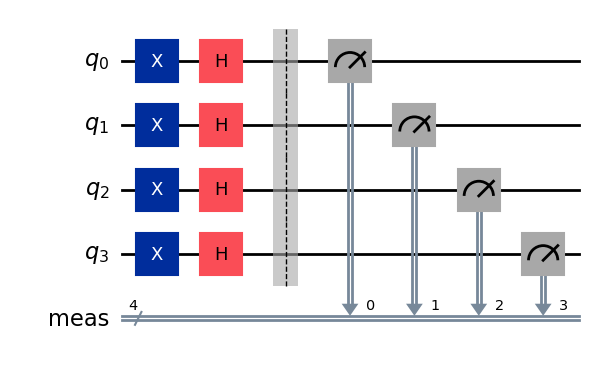

In [189]:
PMx.draw()

# SSS

Now we generate the squeezed spin state of Kitagawa and Ueda (one-axis twisting ot OAT).
We do the squeezing in the $x$ direction, from the coherent state pointing along the $z$ axis.
But, to assure that the minimal and maximal variance occur when measuring $S_x$ and $S_y$, we
rotate the operator in the squeezing Hamiltonian by the twisting angle $-\delta$

In [190]:
#From Kitagawa and Ueda, page 5140
mu = (24)**(1/6)*(N/2)**(-2/3)
A = 1-np.cos(mu)**(N-2)
B = 4*np.sin(mu/2)*np.cos(mu/2)**(N-2)
delta = (1/2)*np.arctan(B/A)
  
squeezing_strength = mu/2

#rotate Sx by -delta before using it as operator inside the squeezing Hamiltonian
rot_spin_oper = (expm(1j * delta  *SzMat) @ SxMat @ expm(-1j * delta  *SzMat))

# The operator introducing the squeezing when applied to a coherent state, written as a Hamiltonian evolution
sqz_op = HamiltonianGate( squeezing_strength * (rot_spin_oper @ rot_spin_oper), 1.0, label="Squeeze")

In [191]:
# Now we measure Sx in every qubit of the squeezed spin state, obtained by
# applying the squeezing operator to the CSS |1> ^{tensor N)
SPMx = QuantumCircuit(4) #Squeezed Phase Measure
for i in range(0,4):
    SPMx.x(i) #CSS = |1> ^\tensor n
SPMx.append(sqz_op,[0,1,2,3]) #squeezing
for i in range(0,4):
    SPMx.h(i) #to measure Sx
SPMx.measure_all()

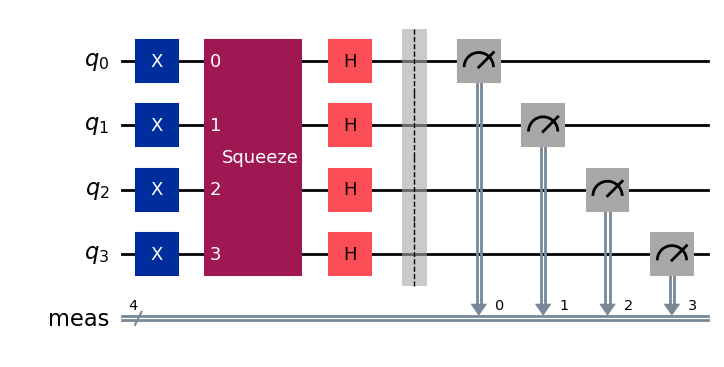

In [192]:
SPMx.draw()

In [193]:
# We relicate the same circuit, but now we measure Sy in every qubit.

SPMy = QuantumCircuit(4) #Squeezed Phase Measure
for i in range(0,4):
    SPMy.x(i) #CSS = |1> ^\tensor n
SPMy.append(sqz_op,[0,1,2,3])
for i in range(0,4):
    SPMy.sdg(i) #to measure Sy
    SPMy.h(i) #to measure Sy
SPMy.measure_all()

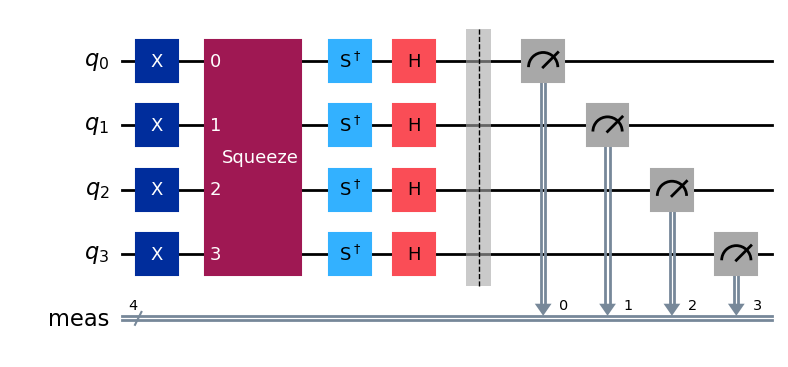

In [194]:
SPMy.draw()

## Running the circuit


Let us get a histogram of the circuits.

In [203]:
# CSS
aer_sim = AerSimulator()
transpiled = transpile(PMx, aer_sim)
result = aer_sim.run(transpiled, shots=65536, memory=True).result()
data = result.get_memory()
statistics = result.get_counts()
output_list = []
for res in data:
    output_list.append(2-res.count("0"))
        
output = {i:0 for i in [-2,-1,0,1,2]}
if "0000" in statistics.keys():
    output[-2] = statistics["0000"]
else:
    output[-2] = 0
output[-1] = statistics["0001"]+statistics["0010"]+statistics["0100"]+statistics["1000"]
output[0] = statistics["0011"]+statistics["0101"]+statistics["0110"]+statistics["1001"]+statistics["1010"]+statistics["1100"]
output[1] = statistics["1110"]+statistics["1101"]+statistics["1011"]+statistics["0001"]
output[2] = statistics["1111"]
print(statistics)
print(output)
print(variance(output_list))

{'1100': 4167, '0011': 4164, '1001': 4115, '0001': 4156, '1111': 3983, '0110': 4203, '0101': 4004, '0111': 4110, '1000': 4151, '1101': 4046, '1010': 3991, '0100': 4114, '1110': 3999, '0000': 4168, '0010': 4113, '1011': 4052}
{-2: 4168, -1: 16534, 0: 24644, 1: 16253, 2: 3983}
0.9969876728914983


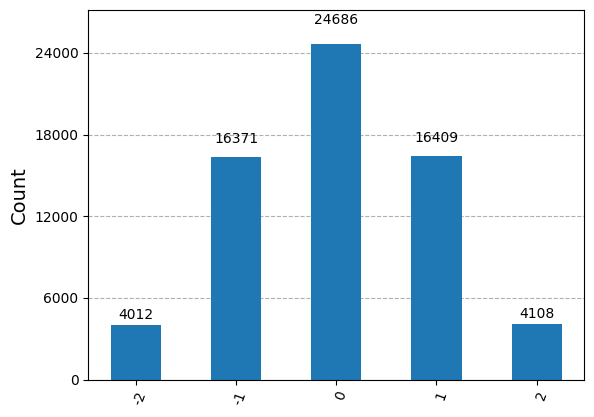

In [183]:
plot_histogram(output)

In [207]:
#SSS, Sx spin (max variance)
aer_sim2 = AerSimulator()
transpiled2 = transpile(SPMx, aer_sim2)
result = aer_sim2.run(transpiled2, shots=65536, memory=True).result()
data = result.get_memory()
statistics = result.get_counts()
output_list = []
for res in data:
    output_list.append(2-res.count("0"))
        
output = {i:0 for i in [-2,-1,0,1,2]}
output[-2] = statistics["0000"]
output[-1] = statistics["0001"]+statistics["0010"]+statistics["0100"]+statistics["1000"]
output[0] = statistics["0011"]+statistics["0101"]+statistics["0110"]+statistics["1001"]+statistics["1010"]+statistics["1100"]
output[1] = statistics["1110"]+statistics["1101"]+statistics["1011"]+statistics["0001"]
output[2] = statistics["1111"]

print(output)
print(variance(output_list))

{-2: 21057, -1: 450, 0: 22758, 1: 428, 2: 20850}
2.571084237093237


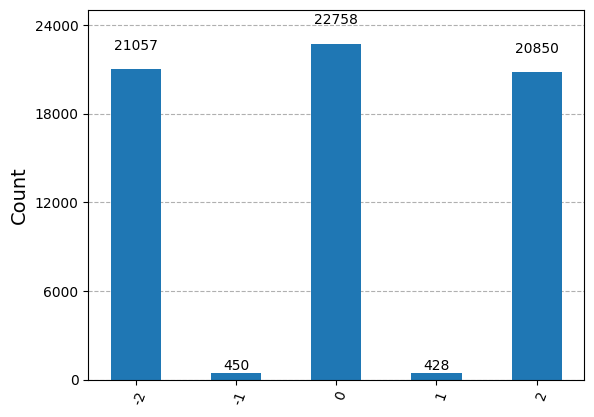

In [208]:
plot_histogram(output)

In [209]:
#SSS, Sy spin (min variance)
aer_sim2 = AerSimulator()
transpiled2 = transpile(SPMy, aer_sim2)
result = aer_sim2.run(transpiled2, shots=65536, memory=True).result()
data = result.get_memory()
statistics = result.get_counts()
output_list = []
for res in data:
    output_list.append(2-res.count("0"))
        
output = {i:0 for i in [-2,-1,0,1,2]}
output[-2] = statistics["0000"]
output[-1] = statistics["0001"]+statistics["0010"]+statistics["0100"]+statistics["1000"]
output[0] = statistics["0011"]+statistics["0101"]+statistics["0110"]+statistics["1001"]+statistics["1010"]+statistics["1100"]
output[1] = statistics["1110"]+statistics["1101"]+statistics["1011"]+statistics["0001"]
output[2] = statistics["1111"]

print(output)
print(variance(output_list))

{-2: 5200, -1: 417, 0: 54125, 1: 451, 2: 5330}
0.6561312561896643


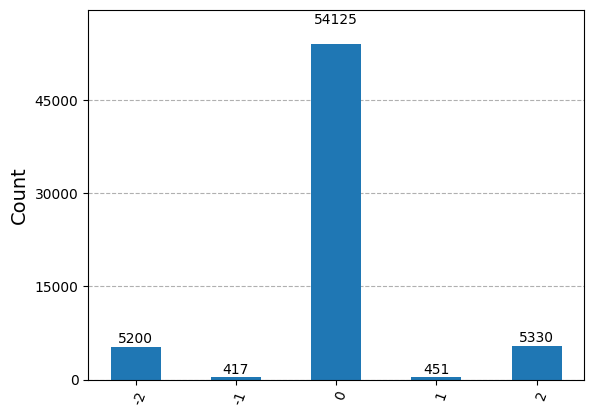

In [210]:
plot_histogram(output)